# Part 2 - Silver layer
- Read brone dataset
- Data cleaning and standardization (optimize data types and partitioning)
- Analytics on data writing/reading speed and size on different file types [feather, parquet, csv, json]
- Utilizing partitioning by year due to potential efficiency in retrieving data by year which is a standard partitioning method.
- If Partitioning by year is not somewhat uniform across the years, we could utilize multi level partitioning, but for our case, it is pretty uniform.

### Imports

In [15]:
# Import Required Libraries
import os
import pandas as pd
from datetime import datetime, timedelta
import random
import json
import findspark
import csv
from io import StringIO
import matplotlib.pyplot as plt
import re
import time

### Finding spark

In [16]:
findspark.init()

# PySpark imports
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import *
    from pyspark.sql.functions import col, when, isnan, isnull, sum as spark_sum
    from pyspark.sql.types import *
    # from pyspark.sql.types import StructType, StructField, StringType

    pyspark_available = True
    print("PySpark is available!")
except ImportError:
    print("PySpark not found. Please install with: pip install pyspark")
    pyspark_available = False

if pyspark_available:
    # Create SparkSession with custom configuration
    spark = SparkSession.builder \
        .appName("DAT535-Project") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "1g") \
        .getOrCreate()
    
    # Set log level to reduce verbose output
    spark.sparkContext.setLogLevel("WARN")
    
    print("✓ SparkSession created successfully!")
    print(f"Spark Version: {spark.version}")
    print(f"Application Name: {spark.sparkContext.appName}")
    print(f"Master: {spark.sparkContext.master}")
    
    # Check available cores and memory
    print(f"Default Parallelism: {spark.sparkContext.defaultParallelism}")
    
else:
    print("Cannot proceed without PySpark. Please install PySpark first.")

PySpark is available!
✓ SparkSession created successfully!
Spark Version: 3.5.0
Application Name: DAT535-Project
Master: local[*]
Default Parallelism: 4


### Input path & inspecting the data

In [17]:
bronze_path = "data/ukprop_bronze.parquet"
bronze_df = spark.read.parquet(bronze_path)
bronze_df.show(3, truncate=True)
bronze_df.select("_raw_data").show(3, truncate=False)

+--------------------+--------------------+--------------------+-------+
|_ingestion_timestamp|           _raw_data|             _source|_status|
+--------------------+--------------------+--------------------+-------+
|  1.76277714302622E9|A newly built lea...|data/ukprop_unstr...|  valid|
|1.7627771430263064E9|A newly built fre...|data/ukprop_unstr...|  valid|
|1.7627771430263145E9|This newly built ...|data/ukprop_unstr...|  valid|
+--------------------+--------------------+--------------------+-------+
only showing top 3 rows

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_raw_data                                               

### Extracting data using rdd and regex

In [18]:
# First regex experiment:
text = 'A newly built leasehold flat with 2 rooms covering 46 sqm. 2 heated rooms, plus energy rating C. Positioned at FLAT 10 BURLEIGH COURT BELMONT ROAD, BELMONT ROAD, in the city of LEATHERHEAD (KT22 7LN). Date of transfer: 2014-07-11, Transaction ID: {5F2B8B60-B9D0-4F00-8561-8BBF0C991BE1}, sold for £187250. The transaction has a record status of Addition and belongs to category: Standard Price Paid entry.'
pattern = r"£([0-9,]+)"

m = re.search(pattern, text, re.IGNORECASE)
for i in range(1, len(m.groups())+1):
    print(i, m.group(i))

1 187250


In [19]:
# Define the explicit schema for the silver layer
silver_schema = StructType([
    StructField("transactionid", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("dateoftransfer", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("postcode", StringType(), True),
    StructField("propertytype", StringType(), True),
    StructField("number_heated_rooms", StringType(), True),
    StructField("floor_height", DoubleType(), True),
    StructField("current_energy_rating", StringType(), True),
    StructField("oldnew", StringType(), True),
    StructField("duration", StringType(), True),
    StructField("locality", StringType(), True),
    StructField("city", StringType(), True),
    StructField("district", StringType(), True),
    StructField("county15", StringType(), True),
    StructField("categorytype", StringType(), True),
    StructField("recordstatus", StringType(), True),
    StructField("tfarea", IntegerType(), True),
    StructField("numberrooms", IntegerType(), True),
    StructField("_source", StringType(), True),
    StructField("_ingestion_timestamp", StringType(), True),
    StructField("_status", StringType(), True)
])

regex = {
    "transaction_id": r"(?:ID|reference:|Transaction ID:)\s*\{?([A-Z0-9\-]+)\}?",
    "price": r"£([0-9,]+)",
    "date": r"(\d{4}-\d{2}-\d{2})",
    "postcode": r"\(([A-Z0-9]{2,4} ?[A-Z0-9]{3})\)",
    "property_type": r"\b(Detached|Semi-detached|Terraced|Flat|Maisonette)\b",
    "oldnew": r"\b(newly built|old)\b",
    "duration": r"\b(freehold|leasehold)\b",
    "tfarea": r"(\d+)\s*(?:sqm|square meters?)",
    "number_rooms": r"(\d+)\s*rooms?\b",
    "heated_rooms": r"(\d+)\s*heated rooms?\b",
    "floor_height": r"(\d+(?:\.\d+)?)\s*meters? high",

    "locality": r"within\s+(?:the city of )?([^,\.]+?)(?=,|\.|$)",
    "city": r"city of\s+([^,\.\(]+)", 
    "district": r"([A-Z][a-zA-Z\s]+?)\s+area",
    "county": r"city of [^,]+,?\s*([A-Z][a-zA-Z]+)(?=\s*\(|\)|\.|,|$)",
    
    "energy_rating": r"energy rating\s*([A-Z])\b",
    
    "paon": r"(?:at|Nestled at|Located at|Found at|Positioned at)\s+([^,(]+)",
    "saon": r"\b(FLAT \d+|Flat \d+|Suite \d+|Unit \d+|Apartment \d+|[0-9]+[A-Z])\b",
    
    "record_status": r"Transaction status:\s*([A-Za-z]+)|record status of\s*([A-Za-z]+)",
    "category_type": r"category:\s*([^,]+)|belongs to category:\s*([^,]+)"
}

# --- Helper functions ---
def extract(pattern, text, dtype = None):
    """Generic regex extractor with optional standardization"""
    m = re.search(pattern, text, re.IGNORECASE)
    if not m:
        return None
    
    # For patterns with multiple capture groups, return the first non-None
    for i in range(1, len(m.groups()) + 1):
        value = m.group(i)
        if value is None:
            continue
        if dtype is not None:
            return standardize(value, dtype)
        return value

    return None

def standardize(text, dtype=str):
    """Stanardizes the data to the decired datatype (dtype)"""
    if not text:
        return None

    text = str(text).strip()

    if dtype is str:
         return text.lower()
    
    if dtype in (int, float):
        text = text.replace(",", ".")
        try:
            value = float(text)
        except ValueError:
            return None
        
        if dtype is int:
            return int(value)
    
        return value

    if dtype is datetime:
        for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%Y/%m/%d"):
            try:
                return datetime.strptime(text, fmt).strftime("%Y-%m-%d")
            except ValueError:
                continue
        return None
    
    return None

# --- Extraction functions ---
def get_transaction_id(text):
    """Extract and clean transaction ID"""
    transaction_id = extract(regex["transaction_id"], text)
    if transaction_id and transaction_id.startswith('{'):
        transaction_id = transaction_id[1:-1] if transaction_id.endswith('}') else transaction_id[1:]
    return standardize(transaction_id, dtype=str)

def get_property_type(text):
    """Extract and normalize property type"""
    property_type = extract(regex["property_type"], text)
    if not property_type and "property" in text.lower():
        property_type = "property"
    return standardize(property_type, dtype=str)

def get_old_new(text):
    """Extract and normalize old/new status"""
    oldnew = extract(regex["oldnew"], text, dtype = str)
    return "new" if oldnew == "new" else "old"

def get_duration(text):
    """Extract and normalize duration"""
    duration = extract(regex["duration"], text, dtype = str)
    return duration if duration in ("leasehold", "freehold") else None

def get_postcode(text):
    """Extract and clean postcode"""
    postcode = extract(regex["postcode"], text)
    if postcode:
        postcode = postcode.replace(" ", "")
    return standardize(postcode, dtype=str)

def get_price(text):
    """Extract and clean price"""
    return extract(regex["price"], text, dtype=float)

# def get_paon_saon_street(text):
#     # Unable to extract this ):
#     """Extract address components"""
#     full_address = extract(regex["paon"], text)
#     street, paon, saon = None, None, None
    
#     if full_address:
#         # Extract saon (Flat/Suite etc.)
#         saon_match = re.search(regex["saon"], full_address, re.IGNORECASE)
#         if saon_match:
#             saon = saon_match.group(0)
#             paon = re.sub(regex["saon"], '', full_address, flags=re.IGNORECASE).strip()
#         else:
#             paon = full_address
        
#         # Extract street name
#         street_parts = paon.split()
#         if len(street_parts) >= 2:
#             street = ' '.join(street_parts[-2:])
    
#     paon = standardize(paon, dtype=str)
#     saon = standardize(saon, dtype=str)
#     street = standardize(street, dtype=str)
    
#     return paon, saon, street

def get_location_components(text):
    """Extract all location-related fields"""
    locality = extract(regex["locality"], text, dtype=str)
    city = extract(regex["city"], text, dtype=str)
    district = extract(regex["district"], text, dtype=str)
    county = extract(regex["county"], text, dtype=str)
    return locality, city, district, county

def get_record_status(text):
    """Extract record status"""
    return extract(regex["record_status"], text, dtype=str)

def get_category_type(text):
    """Extract category type"""
    return extract(regex["category_type"], text, dtype=str)

def get_date_and_year(text):
    """Get the date and the year"""
    date_of_transfer = extract(regex["date"], text, dtype=datetime)
    year = standardize(date_of_transfer[0:4], int)
    
    return date_of_transfer, year

def get_tfarea_fheight(text):
    """Get total floor area and floor height"""
    tfarea = extract(regex["tfarea"], text)
    fheight = extract(regex["floor_height"], text)
    
    tfarea = standardize(tfarea, dtype=int)
    fheight = standardize(fheight, dtype=float)
    
    return tfarea, fheight

def get_room_data(text):
    """Gets the room and heated_room count"""
    number_rooms = extract(regex["number_rooms"], text)
    heated_rooms = extract(regex["heated_rooms"], text)

    number_rooms = standardize(number_rooms, dtype=int)
    heated_rooms = standardize(heated_rooms, dtype=int)
    
    return number_rooms, heated_rooms

def get_energy_rating(text):
    energy_rating = extract(regex["energy_rating"], text, dtype=str)
    if energy_rating not in ["a","b","c","d","e","f","g"]:
       return None
    return energy_rating


### Check handler extraction functions:

In [20]:
text = 'A newly built leasehold flat with 2 rooms covering 46 sqm. 2 heated rooms, plus energy rating C. Positioned at FLAT 10 BURLEIGH COURT BELMONT ROAD, BELMONT ROAD, in the city of LEATHERHEAD (KT22 7LN). Date of transfer: 2014-07-11, Transaction ID: {5F2B8B60-B9D0-4F00-8561-8BBF0C991BE1}, sold for £187250. The transaction has a record status of Addition and belongs to category: Standard Price Paid entry.'
price = extract(regex["price"], text) # r"£([0-9,]+)",
duration = get_location_components(text)
# price = get_paon_saon_street(text)
price

'187250'

In [21]:
sample_rows = bronze_df.select("_raw_data").limit(5).toPandas()["_raw_data"].tolist()
display("---- Example text row 1 ----", sample_rows[0:3],"---- Output 4 rows extracted ----")

results = []
for i, line in enumerate(sample_rows):

    # Cache expensive function calls (I aint got all day)
    date_of_transfer, year = get_date_and_year(text)
    locality, city, district, county15 = get_location_components(text)
    tfarea, floor_height = get_tfarea_fheight(text)
    number_rooms, heated_rooms = get_room_data(text)

    # Handler functions return either the extracted data 
    # in the correct dtype (cleaned, standardized, validated)
    # Or it simply returns None
    r = {
        "transactionid": get_transaction_id(text),
        "price": get_price(text),
        "dateoftransfer": date_of_transfer,
        "year": year, 
        "postcode": get_postcode(text),
        "propertytype": get_property_type(text),
        "number_heated_rooms": heated_rooms,
        "floor_height": floor_height,
        "energy_rating": get_energy_rating(text),
        "oldnew": get_old_new(text),
        "duration": get_duration(text),
        "locality": locality,
        "city": city,
        "district": district,
        "county15": county15,
        "categorytype": get_category_type(text),
        "recordstatus": get_record_status(text),
        "tfarea": tfarea,
        "numberrooms": number_rooms,
        "_source": bronze_path,
        "_ingestion_timestamp": time.time(),
        "_status": "cleaned"
    }
    results.append(r)
df = pd.DataFrame(results)[list(results[0].keys())]
display(df)

'---- Example text row 1 ----'

['A newly built leasehold flat with 2 rooms covering 46 sqm. 2 heated rooms, plus energy rating C. Positioned at FLAT 10 BURLEIGH COURT BELMONT ROAD, BELMONT ROAD, in the city of LEATHERHEAD (KT22 7LN). Date of transfer: 2014-07-11, Transaction ID: {5F2B8B60-B9D0-4F00-8561-8BBF0C991BE1}, sold for £187250. The transaction has a record status of Addition and belongs to category: Standard Price Paid entry.',
 'A newly built freehold terraced property with 5 rooms covering 77 sqm. 5 heated rooms, plus energy rating D. Positioned at 61 BAILEY ROAD, BAILEY ROAD, in the city of DORKING (RH4 3QR). The transaction took place on 2017-10-23 with ID {5F54B81D-B8BA-2B45-E053-6B04A8C01FB0} for £394000. Record status: Addition; Category type: Standard Price Paid entry.',
 'This newly built freehold semi-detached property offers 5 rooms over 139 square meters. This home offers 4 heated rooms, accompanied by energy rating C. Nestled at 58 WEST FARM CLOSE, within the city of ASHTEAD, SURREY (KT21 2LJ). 

'---- Output 4 rows extracted ----'

,transactionid,price,dateoftransfer,year,postcode,propertytype,number_heated_rooms,floor_height,energy_rating,oldnew,...,city,district,county15,categorytype,recordstatus,tfarea,numberrooms,_source,_ingestion_timestamp,_status
0,5f2b8b60-b9d0-4f00-8561-8bbf0c991be1,187250.0,2014-07-11,2014,kt227ln,flat,2,None,c,old,...,leatherhead,None,ln,standard price paid entry.,addition,46,2,data/ukprop_bronze.parquet,1.764056e+09,cleaned
1,5f2b8b60-b9d0-4f00-8561-8bbf0c991be1,187250.0,2014-07-11,2014,kt227ln,flat,2,None,c,old,...,leatherhead,None,ln,standard price paid entry.,addition,46,2,data/ukprop_bronze.parquet,1.764056e+09,cleaned
2,5f2b8b60-b9d0-4f00-8561-8bbf0c991be1,187250.0,2014-07-11,2014,kt227ln,flat,2,None,c,old,...,leatherhead,None,ln,standard price paid entry.,addition,46,2,data/ukprop_bronze.parquet,1.764056e+09,cleaned
3,5f2b8b60-b9d0-4f00-8561-8bbf0c991be1,187250.0,2014-07-11,2014,kt227ln,flat,2,None,c,old,...,leatherhead,None,ln,standard price paid entry.,addition,46,2,data/ukprop_bronze.parquet,1.764056e+09,cleaned
4,5f2b8b60-b9d0-4f00-8561-8bbf0c991be1,187250.0,2014-07-11,2014,kt227ln,flat,2,None,c,old,...,leatherhead,None,ln,standard price paid entry.,addition,46,2,data/ukprop_bronze.parquet,1.764056e+09,cleaned


In [22]:
def handle_unstructured_line(record):
    try:
        text = record["_raw_data"]

        # Cache expensive function calls
        date_of_transfer, year = get_date_and_year(text)
        locality, city, district, county15 = get_location_components(text)
        tfarea, floor_height = get_tfarea_fheight(text)
        number_rooms, heated_rooms = get_room_data(text)

        # Handler functions return either the extracted data 
        # in the correct dtype (cleaned, standardized, validated)
        # Or it simply returns None
        row_dict = {
            "transactionid": get_transaction_id(text),
            "price": get_price(text),
            "dateoftransfer": date_of_transfer,
            "year": year, 
            "postcode": get_postcode(text),
            "propertytype": get_property_type(text),
            "number_heated_rooms": heated_rooms,
            "floor_height": floor_height,
            "energy_rating": get_energy_rating(text),
            "oldnew": get_old_new(text),
            "duration": get_duration(text),
            "locality": locality,
            "city": city,
            "district": district,
            "county15": county15,
            "categorytype": get_category_type(text),
            "recordstatus": get_record_status(text),
            "tfarea": tfarea,
            "numberrooms": number_rooms,
            "_source": bronze_path,
            "_ingestion_timestamp": time.time(),
            "_status": "cleaned"
        }
        
        # Crucial for house price predictions (Price and tfarea), year for partitioning
        if None in (row_dict["price"], row_dict["tfarea"], row_dict["year"]):
            return None

        # Remove dog houses, xd
        if row_dict["price"] < 1000 or row_dict["tfarea"] < 2:
            return None

        # print(row_dict)
        return Row(**row_dict)
        
    except Exception as e:
        print(f"Error cleaning record: {e}")
        return None

start = time.time()

silver_rdd = bronze_df.rdd.map(handle_unstructured_line) 
silver_rdd = silver_rdd.filter(lambda row: row is not None)

# Enforcing the schema
df_silver = spark.createDataFrame(silver_rdd, schema=silver_schema)

silver_records = df_silver.count()
end = time.time()

bronze_records = bronze_df.count()

print(f"Time taken to clean the data {end-start} seconds")
print(f"Number of records in cleaned RDD: {silver_records}")
print(f"Data loss: {bronze_records - silver_records} {(1 - silver_records/bronze_records)*100} %")

[Stage 25:================================================>         (5 + 1) / 6]

Time taken to clean the data 0.08347010612487793 seconds
Number of records in cleaned RDD: 5499993
Data loss: 232845 4.061600903426887 %


In [24]:
duplicate_count = silver_records - df_silver.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

25/11/25 07:57:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:57:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:57:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:57:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:57:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:57:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/25 07:59:36 WARN RowBasedKeyValueBatch: Calling spill() on

Number of duplicate rows: 0


In [25]:
df_silver.show(2, truncate=True)

[Stage 35:>                                                         (0 + 1) / 1]

+--------------------+--------+--------------+----+--------+------------+-------------------+------------+---------------------+------+---------+--------+-----------+--------+--------+--------------------+------------+------+-----------+--------------------+--------------------+-------+
|       transactionid|   price|dateoftransfer|year|postcode|propertytype|number_heated_rooms|floor_height|current_energy_rating|oldnew| duration|locality|       city|district|county15|        categorytype|recordstatus|tfarea|numberrooms|             _source|_ingestion_timestamp|_status|
+--------------------+--------+--------------+----+--------+------------+-------------------+------------+---------------------+------+---------+--------+-----------+--------+--------+--------------------+------------+------+-----------+--------------------+--------------------+-------+
|5f2b8b60-b9d0-4f0...|187250.0|    2014-07-11|2014| kt227ln|        flat|                  2|        NULL|                    c|   old|l

### Check null values and duplicates

In [27]:
from pyspark.sql.functions import col, when, isnan, isnull, sum as spark_sum

misnull = df_silver.select([
    spark_sum(when(isnan(c) | isnull(c), 1).otherwise(0)).alias(c)
    for c in df_silver.columns
])
misnull.show()
# display(misnull.toPandas())

[Stage 36:================================================>         (5 + 1) / 6]

+-------------+-----+--------------+----+--------+------------+-------------------+------------+---------------------+------+--------+--------+----+--------+--------+------------+------------+------+-----------+-------+--------------------+-------+
|transactionid|price|dateoftransfer|year|postcode|propertytype|number_heated_rooms|floor_height|current_energy_rating|oldnew|duration|locality|city|district|county15|categorytype|recordstatus|tfarea|numberrooms|_source|_ingestion_timestamp|_status|
+-------------+-----+--------------+----+--------+------------+-------------------+------------+---------------------+------+--------+--------+----+--------+--------+------------+------------+------+-----------+-------+--------------------+-------+
|            0|    0|             0|   0|       0|           0|                  0|     3434644|                    0|     0|       0| 4399900|   0| 5499992|       0|     2749131|     2749131|     0|          0|      0|                   0|      0|
+---

### Comparing writing time

In [29]:
frac = 0.01
test_df = df_silver.sample(withReplacement=False, fraction=frac, seed=42) 
print("test_df created with record_count", silver_records * frac)

test_df created with record_count 54999.93


In [33]:
def write(file_type, func):
    path = f"data/test/ukprop_silver_test.{file_type}"
    start_time = time.time()
    func[file_type](path)
    end_time = time.time()
    writing_time = end_time - start_time
    print(f"Silver layer saved to {file_type} in {writing_time:.2f} seconds")

    return writing_time

file_function = {
    "parquet": test_df.write.mode("overwrite").option("header", "true").parquet,
    "csv": test_df.write.mode("overwrite").option("header", "true").csv,
    "json": test_df.write.mode("overwrite").option("header", "true").json,
    "feather": test_df.toPandas().to_feather
}

writing_times = pd.DataFrame({"writing_times": [
    write("parquet", file_function),
    write("csv", file_function),
    write("json", file_function),
    write("feather", file_function)
]})

# barplot(writing_times.keys(),writing_times.values(),xlabel="File Format",ylabel="Time (seconds)",title="File Writing Time Comparison",bar_text_end="s")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
                                                                                

Silver layer saved to parquet in 582.50 seconds


Silver layer saved to csv in 580.56 seconds


Silver layer saved to json in 579.36 seconds
Silver layer saved to feather in 0.36 seconds


### Comparing reading time and file size

In [66]:
writing_times = writing_times.rename(columns={"writing_times": "writing_times (s)"})

In [71]:
import builtins   # to access the real Python sum

def get_file_size(file_type):
    # path = f"data/test/ukprop_silver_test.{file_type}"
    # folder = Path(path)
    # print(type(folder))
    path = Path(f"data/test/ukprop_silver_test.{file_type}")


    if path.is_dir():
        total_size = builtins.sum(f.stat().st_size for f in path.glob("*") if f.is_file())

    elif path.is_file():
        total_size = path.stat().st_size
    else:
        total_size = 0

    return total_size / (1024 * 1024)

def timed_read(file_type, func):
    path = f"data/test/ukprop_silver_test.{file_type}"
    t0 = time.time()
    df = func(path)
    dt = time.time() - t0
    # print(f"{file_type}: {dt:.2f} seconds")
    return dt

file_size = pd.DataFrame({"file_size": [
    get_file_size("parquet"),
    get_file_size("csv"),
    get_file_size("json"),
    get_file_size("feather")
]})

read_time = pd.DataFrame({"read_time": [
    timed_read("parquet", spark.read.parquet),
    timed_read("csv", spark.read.csv),
    timed_read("json", spark.read.json),
    timed_read("feather", pd.read_feather)
]})

file_size = file_size.rename(columns={"file_size": "file_size (mb)"})
read_time = read_time.rename(columns={"read_time": "read_time (s)"})

combined = pd.concat([writing_times,file_size, read_time], axis=1)
combined.index="parquet,csv,json,feather".split(",")
display(combined)

,writing_times (s),file_size (mb),read_time (s)
parquet,582.495661,2.645638,0.078357
csv,580.557273,10.280720,0.124189
json,579.359886,24.870874,0.126630
feather,0.356977,6.170992,0.071458


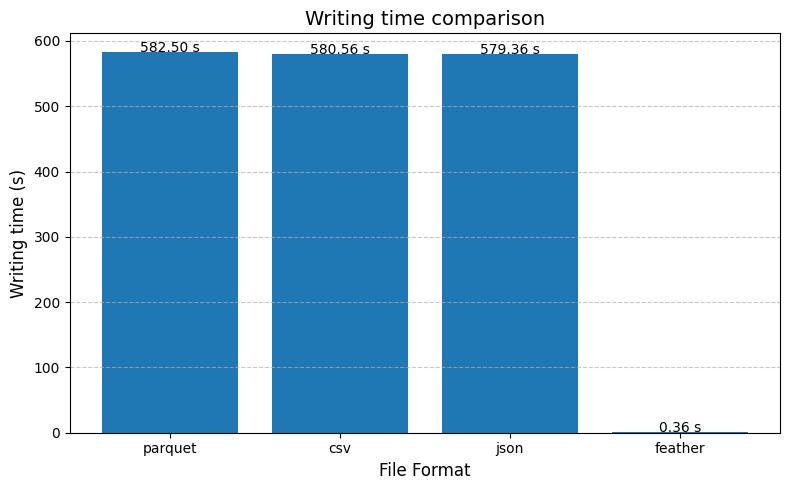

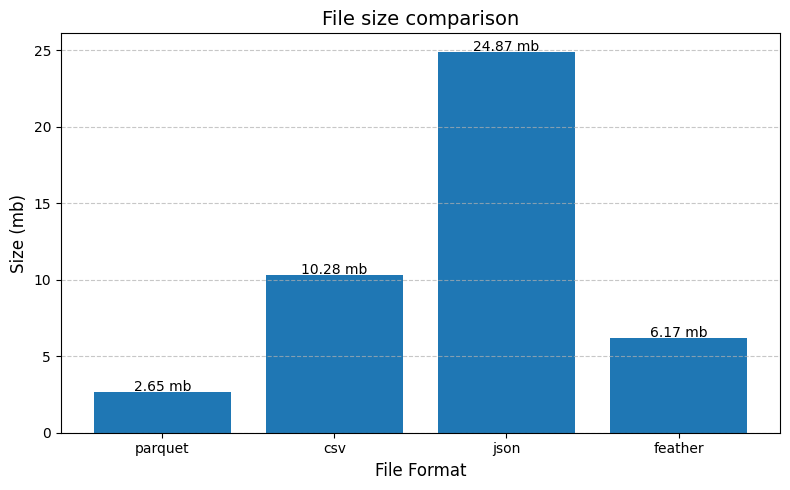

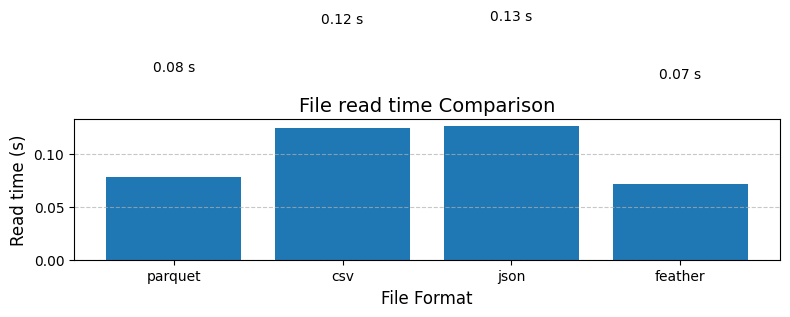

In [101]:
def barplot(x, y, xlabel, ylabel, title, size=(8, 5), bar_text=True, bar_text_end=""):
    plt.figure(figsize=size)
    plt.bar(x, y)

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    if bar_text:
        for i, v in enumerate(y):
            plt.text(i, v + 0.1, f"{v:.2f}{bar_text_end}", ha="center", fontsize=10)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

barplot(
    x=list(combined.index),
    y=combined["writing_times (s)"].values,
    xlabel="File Format",
    ylabel="Writing time (s)",
    title="Writing time comparison",
    size=(8, 5),
    bar_text=True,
    bar_text_end=" s",
)
barplot(
    x=list(combined.index),
    y=combined["file_size (mb)"].values,
    xlabel="File Format",
    ylabel="Size (mb)",
    title="File size comparison",
    size=(8, 5),
    bar_text=True,
    bar_text_end=" mb",
)
barplot(
    x=list(combined.index),
    y=combined["read_time (s)"].values,
    xlabel="File Format",
    ylabel="Read time (s)",
    title="File read time Comparison",
    size=(8, 5),
    bar_text=True,
    bar_text_end=" s",
)


### Final writing (partitioning data by year in the best file type .parquet)

In [72]:
silver_path = "data/ukprop_silver.parquet"

start_time = time.time()

#df_silver.write.mode("overwrite").partitionBy("year").parquet(final_path)
df_silver.coalesce(1).write.mode("overwrite").partitionBy("year").option("header", "true").parquet(silver_path)
end_time = time.time()
final_writing_time = end_time-start_time

print(f"Silver layer saved to {silver_path}")
print(f"Time taken to write Parquet: {final_writing_time:.2f} seconds")

### END OF SILVER